In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import *
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [2]:
from utils import visualize_clusters, cluster_and_visualize, plot_elbow_silhouette

In [3]:
train_df, test_df = pd.read_csv("data/train.csv"), pd.read_csv("data/test.csv")
features_df = pd.read_csv("data/features.csv")
stores_df = pd.read_csv("data/stores.csv")

In [4]:
train_df = (train_df
            .merge(features_df, how='inner', indicator='indicator_column')
            .merge(stores_df, how='inner'))
train_df.drop(columns=['indicator_column'], axis=1, inplace=True)

In [5]:
train_df = train_df.loc[train_df['Weekly_Sales'] > 0] #outliers

train_df.fillna(0, inplace=True)
train_df['Total_MarkDown'] = train_df[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum(axis=1).astype(float)

In [6]:
train_df.isna().sum()

Store             0
Dept              0
Date              0
Weekly_Sales      0
IsHoliday         0
Temperature       0
Fuel_Price        0
MarkDown1         0
MarkDown2         0
MarkDown3         0
MarkDown4         0
MarkDown5         0
CPI               0
Unemployment      0
Type              0
Size              0
Total_MarkDown    0
dtype: int64

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 420212 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Store           420212 non-null  int64  
 1   Dept            420212 non-null  int64  
 2   Date            420212 non-null  object 
 3   Weekly_Sales    420212 non-null  float64
 4   IsHoliday       420212 non-null  bool   
 5   Temperature     420212 non-null  float64
 6   Fuel_Price      420212 non-null  float64
 7   MarkDown1       420212 non-null  float64
 8   MarkDown2       420212 non-null  float64
 9   MarkDown3       420212 non-null  float64
 10  MarkDown4       420212 non-null  float64
 11  MarkDown5       420212 non-null  float64
 12  CPI             420212 non-null  float64
 13  Unemployment    420212 non-null  float64
 14  Type            420212 non-null  object 
 15  Size            420212 non-null  int64  
 16  Total_MarkDown  420212 non-null  float64
dtypes: bool(1), flo

In [8]:
times_without_markdowns = [train_df['Date'][i] for i in range(40, 91)]
times_with_markdowns = [train_df['Date'][i] for i in range(92, 143)]

In [9]:
print(train_df['Date'].unique().tolist())

['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02', '2010-04-09', '2010-04-16', '2010-04-23', '2010-04-30', '2010-05-07', '2010-05-14', '2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16', '2010-07-23', '2010-07-30', '2010-08-06', '2010-08-13', '2010-08-20', '2010-08-27', '2010-09-03', '2010-09-10', '2010-09-17', '2010-09-24', '2010-10-01', '2010-10-08', '2010-10-15', '2010-10-22', '2010-10-29', '2010-11-05', '2010-11-12', '2010-11-19', '2010-11-26', '2010-12-03', '2010-12-10', '2010-12-17', '2010-12-24', '2010-12-31', '2011-01-07', '2011-01-14', '2011-01-21', '2011-01-28', '2011-02-04', '2011-02-11', '2011-02-18', '2011-02-25', '2011-03-04', '2011-03-11', '2011-03-18', '2011-03-25', '2011-04-01', '2011-04-08', '2011-04-15', '2011-04-22', '2011-04-29', '2011-05-06', '2011-05-13', '2011-05-20', '2011-05-27', '2011-06-03', '2011-06-10', '2011

In [10]:
# data with markdowns period
print(train_df['Date'].unique().tolist().index('2011-11-11'))
print(train_df['Date'].unique().tolist().index('2012-10-26'))

92
142


In [11]:
# data without markdowns period
print(train_df['Date'].unique().tolist().index('2010-11-12'))
print(train_df['Date'].unique().tolist().index('2011-10-28'))

40
90


In [12]:
data_without_markdown = train_df[train_df['Date'].isin(times_without_markdowns)]
data_with_markdown = train_df[train_df['Date'].isin(times_with_markdowns)]

# Testing Normality Assumption

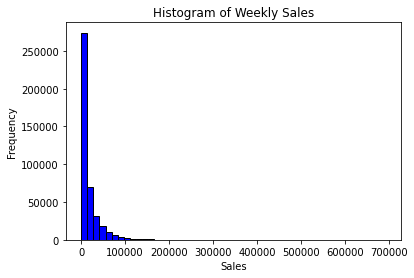

In [13]:
plt.hist(train_df['Weekly_Sales'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

### BoxCox transformation

In [14]:
train_df['boxcox_sales'], _ = boxcox(train_df['Weekly_Sales'])

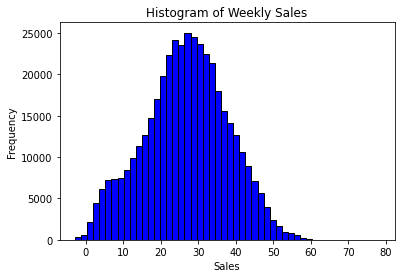

In [15]:
plt.hist(train_df['boxcox_sales'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

# Markdowns 

In [16]:
# Split data into two groups: days with markdowns and days without markdowns
sales_with_markdown = data_with_markdown['Weekly_Sales'] # Nov 11 to Oct 26 [2012]
sales_without_markdown = data_without_markdown['Weekly_Sales'] # Nov 12 to Oct 28 [2011]

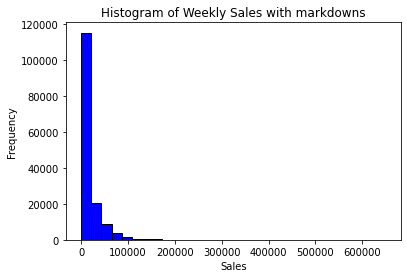

In [17]:
plt.hist(sales_with_markdown, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales with markdowns')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

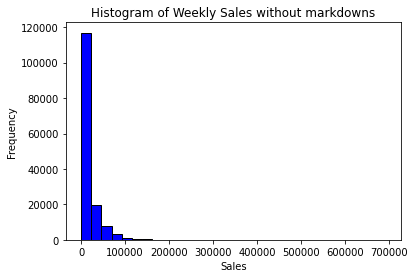

In [18]:
plt.hist(sales_without_markdown, bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Weekly Sales without markdowns')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

In [19]:
print(sales_with_markdown.shape)
print(sales_without_markdown.shape)

(150929,)
(149535,)


In [20]:
print(sales_with_markdown.mean())
print(sales_without_markdown.mean())

16231.116040721136
16021.836361788208


In [21]:
# Assuming you've already computed the descriptives as:
stats_without_markdowns = data_without_markdown[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe()
stats_with_markdowns = data_with_markdown[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].describe()

# Compute the differences in means:
difference_in_means = stats_with_markdowns.loc['mean'] - stats_without_markdowns.loc['mean']

print("Difference in Means (With Markdowns - Without Markdowns):\n")
print(difference_in_means)

Difference in Means (With Markdowns - Without Markdowns):

Temperature     1.535219
Fuel_Price      0.160912
CPI             4.436657
Unemployment   -0.745140
Name: mean, dtype: float64


--- 

# Clustering Stores

In [22]:
from umap.umap_ import UMAP
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Assuming train_df is your DataFrame containing the data
data = train_df.drop("Date", axis="columns").sample(frac=0.4, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('encoder', OrdinalEncoder()),
    ('scaler', StandardScaler()),
    ('umap', UMAP(n_components=2, n_jobs=-1, random_state=42))
])

# Fit and transform the data using method chaining
transformed_data = pipeline.fit_transform(data)

c:\Users\Mahmoud\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Mahmoud\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Mahmoud\AppData\Local\Programs\Python\P

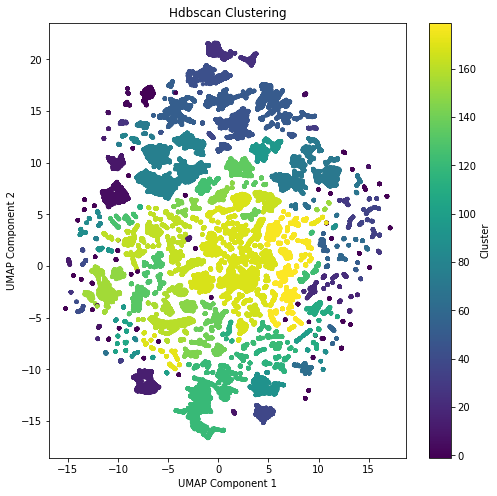

In [23]:
# Example usage:
visualize_clusters('hdbscan', transformed_data, min_cluster_size=60, cluster_selection_epsilon=0.6)
# visualize_clusters('gmm', transformed_data, n_components=6, random_state=42)
# visualize_clusters('kmeans', transformed_data, n_clusters=6, random_state=42)

In [24]:
features = {
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean',
    "Total_MarkDown": "mean"
}

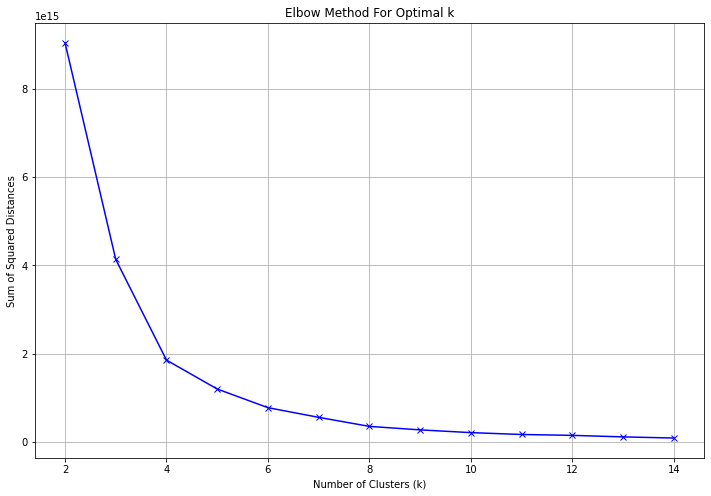

In [25]:
plot_elbow_silhouette(data_with_markdown, 'Store', features, range(2, 15), method='elbow', figsize=(12, 8), random_state=42)

c:\Users\Mahmoud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


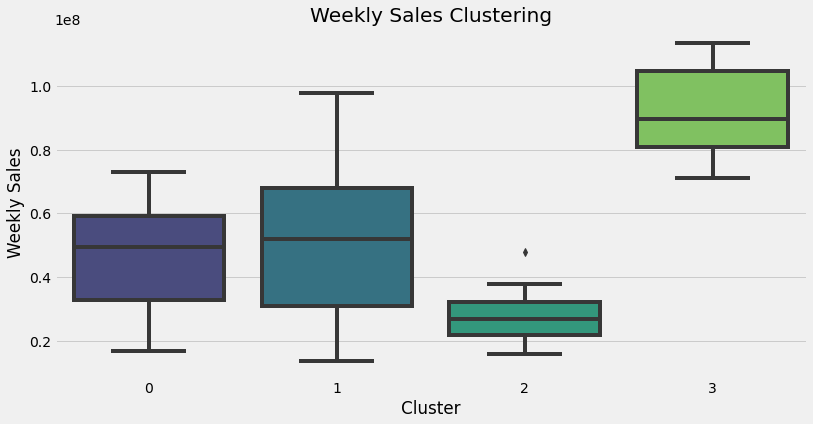

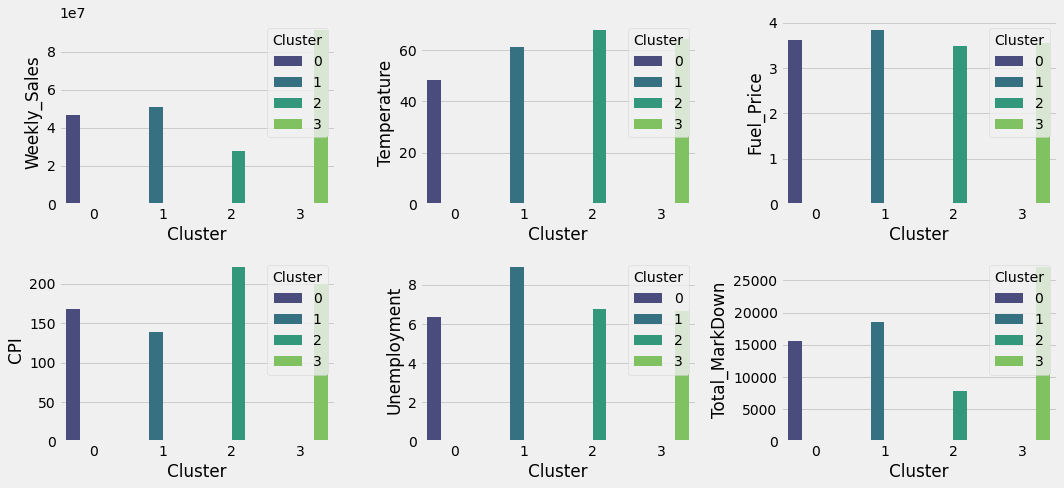

Cluster Details for Stores:


{'Cluster 0': {'Stores': array([ 7, 16, 17, 23, 25, 26, 32, 40, 41, 44], dtype=int64),
  'No. of Stores': 10},
 'Cluster 1': {'Stores': array([10, 12, 15, 18, 19, 22, 24, 27, 28, 29, 33, 34, 35, 38, 42, 45],
        dtype=int64),
  'No. of Stores': 16},
 'Cluster 2': {'Stores': array([ 3,  5,  8,  9, 21, 30, 36, 37, 43], dtype=int64),
  'No. of Stores': 9},
 'Cluster 3': {'Stores': array([ 1,  2,  4,  6, 11, 13, 14, 20, 31, 39], dtype=int64),
  'No. of Stores': 10},
 'Total': 45}

In [26]:
# Call the function with your dataset
cluster_and_visualize(data_with_markdown, features, target='Store', algorithm='kmeans', n_components=4,
                       visualize_flag=True, colors='viridis', style='fivethirtyeight', figsize=(12, 6), title='Weekly Sales Clustering')

# Clustering Departments

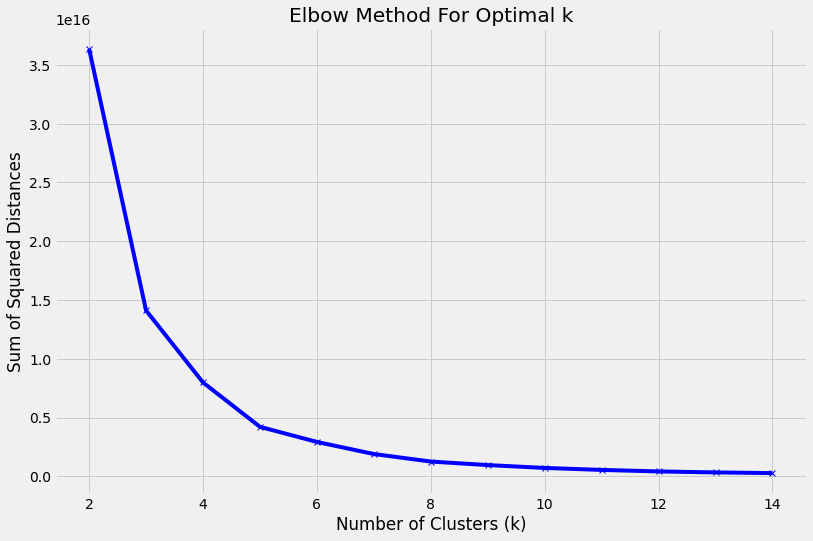

In [27]:
plot_elbow_silhouette(data_with_markdown, 'Dept', features, range(2, 15), method='elbow', figsize=(12, 8), random_state=42)

In [28]:
# Call the function with your dataset
cluster_and_visualize(data_with_markdown, features, target='Dept', algorithm='kmeans', n_components=4,
                       visualize_flag=False, colors='viridis', style='fivethirtyeight', figsize=(12, 6), title='Weekly Sales Clustering')

Cluster Details for Depts:


c:\Users\Mahmoud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'Cluster 0': {'Depts': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55,
         56, 58, 59, 60, 67, 71, 72, 74, 79, 80, 81, 82, 83, 85, 87, 90, 91,
         92, 93, 94, 95, 96, 97, 98, 99], dtype=int64),
  'No. of Depts': 76},
 'Cluster 1': {'Depts': array([65], dtype=int64), 'No. of Depts': 1},
 'Cluster 2': {'Depts': array([39], dtype=int64), 'No. of Depts': 1},
 'Cluster 3': {'Depts': array([43, 77, 78], dtype=int64), 'No. of Depts': 3},
 'Total': 81}

In [29]:
# Call the function with your dataset
cluster_and_visualize(data_with_markdown, features, target='Dept', algorithm='gmm', n_components=4,
                       visualize_flag=False, colors='viridis', style='fivethirtyeight', figsize=(12, 6), title='Weekly Sales Clustering')

Cluster Details for Depts:


{'Cluster 0': {'Depts': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55,
         56, 58, 59, 60, 67, 71, 72, 74, 79, 80, 81, 82, 83, 85, 87, 90, 91,
         92, 93, 94, 95, 96, 97, 98, 99], dtype=int64),
  'No. of Depts': 76},
 'Cluster 1': {'Depts': array([65], dtype=int64), 'No. of Depts': 1},
 'Cluster 2': {'Depts': array([39], dtype=int64), 'No. of Depts': 1},
 'Cluster 3': {'Depts': array([43, 77, 78], dtype=int64), 'No. of Depts': 3},
 'Total': 81}